## Grupo:
- Ricardo Ribeiro Rodrigues.
- Guilherme Fontana Louro.
- Pedro Henrique Andrade.

# Primeira etapa - Simulações numéricas essenciais.

## Sumário
- [Diagrama do modelo](#diagrama)
- Sistema antes da iteração:
    - [Declaração de constantes](#constantes)
    - Modelo inicial - fonte DC: 
        - [Código do modelo numérico](#modeloDC)
        - [Gráficos das correntes por frequência](#grafico-i-f)
        - [Gráficos das potências e da eficiencia](#grafico-p-e)
        - [Gráfico da tensão no secundário por k](#grafico-s-k)
    - [Etapa 2 - Atividades](#etapa2)
        - [Montagem do circuito de alimentação do primário](#montagem-primario)
        - [Escolha dos componentes](#escolha)
        - [Montagem das bobinas](#montagem-bobina)
        - [Modelo atualizado - onda quadrada](#atualiza)
            - [Gráficos das correntes por frequência](#grafico-i-fq)
            - [Gráficos das potências e da eficiência](#grafico-p-eq)
            - [Gráfico da tensão no secundário por k](#grafico-s-k-q)
        - [Resultados iniciais](#res-ini)
- [Iterando sobre os resultados:](#iter)
    - [Novo circuito primário](#novo-circ)
    - [Gráfico das correntes por frequência](#grafico-i-fq-iter)
    - [Gráficos das potências e da eficiencia](#grafico-p-eq-iter) 
    - [Resultados finais](#res-fin)

<div id="diagrama"/>

___

### 1) Diagrama do modelo eletrodinâmico do circuito WPT
![Circuito](imgs/CircuitoWPT.png)

### Imports necessários para o projeto

In [1]:
import math
from cmath import *
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

<div id="constantes"></div>

___

## Declaração de constantes

In [2]:
R1 = 0.4577 * 4.5
R2 = 0.4594 * 4.5
L1 = 0.1375e-3
L2 = 0.1370e-3
C1 = C2 = 0.1e-6
k = 0.1
RC = 100
UF = 10

<div id='calcSim'></div>

## Cálculos e simulações

In [3]:
m = k * math.sqrt(L1 * L2)
w = 1 / (math.sqrt(L1 * C1))
f_res = w / (2 * pi)
f_res

42920.89629716038

<div id="modeloDC"></div>

___

### 2) Código do modelo numérico

In [4]:
def CalcularTransformador(Uf, Rc, w, k):
    """
    Função para calcular as correntes no primário e secundário.
    
    Parâmetros:
        - Uf: Tensão da fonte no primário.
        - Rc: Resistência da carga no secundário.
        - w: Frequência angular da fonte.
        - k: Constante de acoplamento do sistema.
    Retorno: 
        - i1: Corrente fasorial no primário.
        - i2: Corrente fasorial no secundário.
    """
    XL1 = w * L1 * 1j
    XC1 = 1/(w * C1 * 1j)
    XM = m * w * 1j
    XL2 = w * L2 * 1j
    XC2 = 1 / (w * C2 * 1j)
    # Associacao em paralelo de C2 e Rc
    Zrc_c2 = (Rc * XC2) / (Rc + XC2)
    Z = np.array([[R1 + XL1 + XC1, -XM], [-XM, XL2 + R2 + Zrc_c2]])
    V = np.array([Uf, 0])
    i = np.dot(linalg.inv(Z), V)
    return i[0], i[1]

<div id='grafico-i-f'></div>

___

### 3) Gráficos de $I_1$ e $I_2$ em função da frequência.

Freq onde o I1 e max: 43081.0, chega próximo à frequência de resonância da atividade 1, porém não coincide.


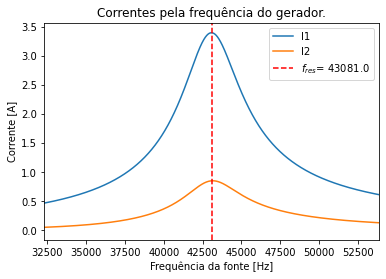

In [5]:
i1_list = []
i2_list = []
freqs = np.linspace(1, 150_000, 150_000)
k = 0.1
m = k * math.sqrt(L1 * L2)

for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(UF, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}, chega próximo à frequência de resonância da atividade 1, porém não coincide.")

ponto_ressonancia = (f_res, max(np.abs(i1_list)))

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.axvline(f_res, color='red', linestyle='dashed', label=f'$f_{{res}}$= {f_res:.1f}')
plt.title("Correntes pela frequência do gerador.")
plt.xlabel('Frequência da fonte [Hz]')
plt.ylabel("Corrente [A]")
plt.legend()
plt.xlim(f_res - 0.25 * f_res, f_res + 0.25 * f_res)
plt.show()

<div id="grafico-p-e"></div>

___

### 4) Gráficos das potências e da eficiência em função da frequência.

Potencia maxima no secundario: 4.357226887474901


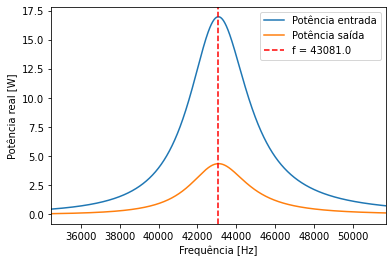

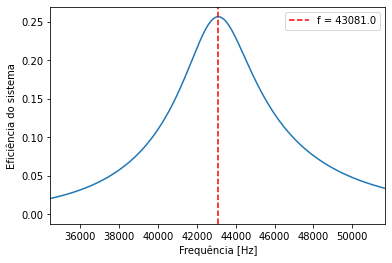

In [6]:
p_1 = []
p_2 = []

for i, freq in enumerate(freqs):
    p_1.append((UF * i1_list[i].conjugate()) / 2)
    z_c2 = 1 / (freq * 2 * pi * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2_list[i]
    i_rc = u_rcc2 / RC 
    p_2.append((u_rcc2 * i_rc.conjugate()) / 2)

eficiencia = [np.abs(p_2[i]) / np.abs(p_1[i]) for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]
print(f"Potencia maxima no secundario: {np.abs(max(p_2))}")

plt.plot(freqs, np.real(p_1), label='Potência entrada')
plt.plot(freqs, np.real(p_2), label='Potência saída')
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.xlabel("Frequência [Hz]")
plt.ylabel("Potência real [W]")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.legend()
plt.show()

plt.plot(freqs, np.real(eficiencia))
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.legend()
plt.xlabel("Frequência [Hz]")
plt.ylabel("Eficiência do sistema")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.show()

<div id="grafico-s-k"></div>

___

### 5) Gráfico da tensão no secundário por k

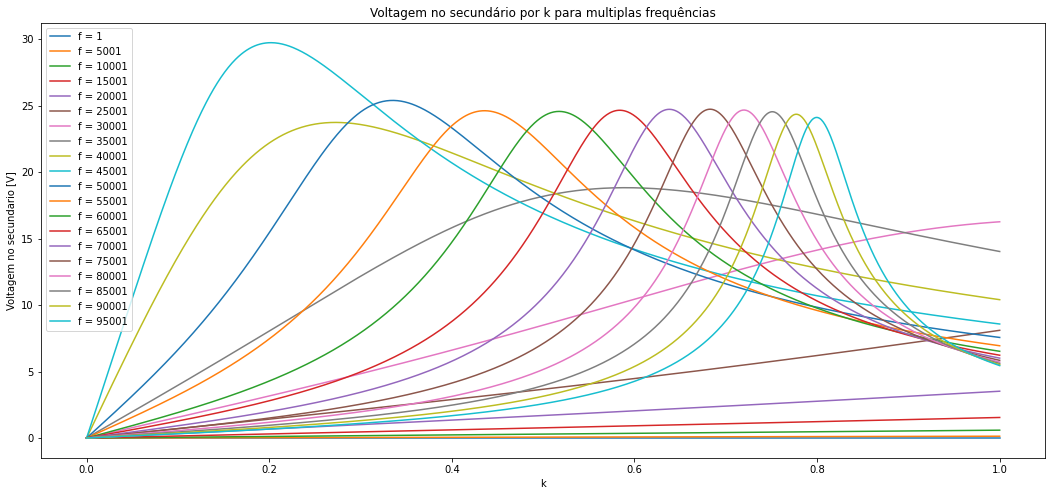

In [7]:
fig = plt.figure(figsize=(18, 8))
k_space = np.linspace(0, 1, 1000)
for f in range(1, 100_000, 5_000):
    v_2 = []
    for k in k_space:
        w = 2 * pi * f
        m = k * math.sqrt(L1 * L2)       
        i1, i2 = CalcularTransformador(UF, RC, w, k)
        z_c2 = 1 / (w * C2 * 1j)
        z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
        # Tensão no secundário
        u_rcc2 = z_rcc2 * i2

        v_2.append(np.abs(u_rcc2))
    plt.plot(k_space, v_2, label=f"f = {f}")

plt.title("Voltagem no secundário por k para multiplas frequências")
plt.xlabel("k")
plt.ylabel("Voltagem no secundario [V]")
plt.legend(loc='upper left')
plt.show()

<div id='etapa2'></div>

___


## Etapa 2 - Parte prática de montagem e projeto dos circuitos.

<div id="montagem-primario"></div>

### 1) Montagem do circuito de alimentação do primário. 
Em seguida, foi montado em uma protoboard o circuito que irá alimentar o primário do sistema, o resultado da montagem pode ser observado nas imagens abaixo.

![Montagem na protoboard circuito alimentacao 1](imgs/montagemPrimario.jpg)
![Montagem na protoboard circuito alimentacao 2](imgs/montagemPrimario2.jpg)

<div id='escolha'></div>

___

### 2) Etapa de projeto das bobínas de transmissão e recepção + escolha do capacitor para o circuito.
Metodologia: 
- Fixar um dos dois: C ou F.
- Escolher uma frequência de ressonância.
- Calcular o F/C mais adequado (Minimizar a reatância).   

Selecionar um dos capacitores disponíveis (listados abaixo):
- $0.1 \mu F$
- $150 nF$
- $1 \mu F$
- $4.7 \mu F$
- $0.47 \mu F$   
Escolhido o capacitor, calcular a indutância da bobina que minimiza a reatância com a eq:
$$L\cdot \omega \cdot j = \dfrac{j}{\omega \cdot C}$$    
Com esse valor calculado, pode-se usar o site [Physika](https://physika.info/site/aplicativos/javascript/inkalc.htm) para obter os parâmetros construtivos da bobina.



In [8]:
w_fixado = 50_000 * 2 * np.pi
C_escolhido = 0.1e-6
L_calculado = 1 / (w_fixado ** 2 * C_escolhido)
print(f"L da bobina a ser montada: {L_calculado * 1000} mH")
print(
    "O valor deve ser colocado no physica juntamente com o fio a ser usado e o diâmetro para saber os parâmetros construtivos da bobina."
)

L da bobina a ser montada: 0.10132118364233779 mH
O valor deve ser colocado no physica juntamente com o fio a ser usado e o diâmetro para saber os parâmetros construtivos da bobina.


<div id="montagem-bobina"></div>

___

### 3) Montagem das bobinas primária e secundária.
Calculados os valores, estes foram colocados no Physika conforme a imagem abaixo.

![Montagem bobina indicada physika](imgs/BobinaPhysika.png)

Com essa simulação, foi montado no laboratório do Insper as seguintes bobinas:

![Imagem das bobinas](imgs/bobinas.jpg)

Construídas as bobinas, medimos suas resistências e indutâncias no LCR, como pode ser visto nas imgens abaixo:

<div style="display: flex; flex-direction: row;">
    <img style="width: 35%; margin-right: 1rem;" src="imgs/ResistenciaBobinaLCR.jpg" alt="Medicao no LCR da bobina"/>
    <img style="width: 35%; margin-right: 1rem;" src="imgs/bobina2lcr.jpg" alt="Medicao no LCR da bobina"/>
    
</div>

<div id='atualiza'></div>

___

### 4) Atualizando o modelo para onda quadrada
$$V1(t) = \dfrac{2}{\pi} \cdot V_p \cdot cos(wt)$$

In [9]:
UFQ = (2 / np.pi) * UF

<div id="grafico-i-fq"></div>

___

### Gráfico das correntes em função da frequência com o modelo atualizado.

Freq onde o I1 e max: 43081.0


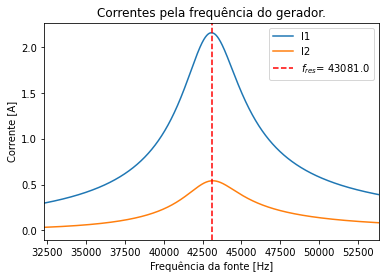

In [10]:
i1_list = []
i2_list = []
k = 0.1

m = k * math.sqrt(L1 * L2)   

for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(UFQ, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}")

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.axvline(f_res, color='red', linestyle='dashed', label=f'$f_{{res}}$= {f_res:.1f}')
plt.title("Correntes pela frequência do gerador.")
plt.xlabel('Frequência da fonte [Hz]')
plt.ylabel("Corrente [A]")
plt.legend()
plt.xlim(f_res - 0.25 * f_res, f_res + 0.25 * f_res)
plt.show()

<div id='grafico-p-eq'></div>

___

### Gráficos das potências e eficiência com o modelo atualizado.

Potencia maxima no secundario: 1.7659175425487057 W


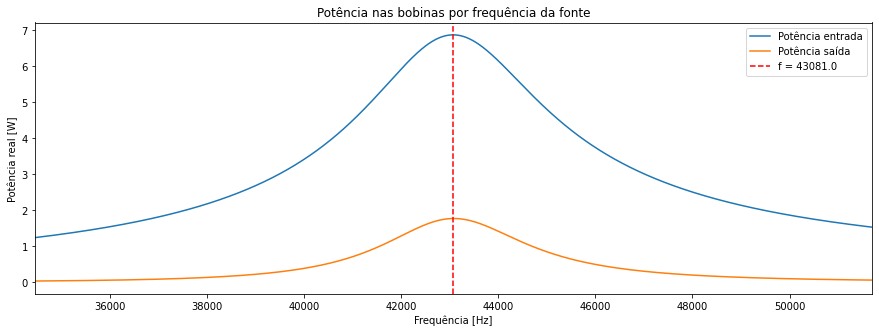

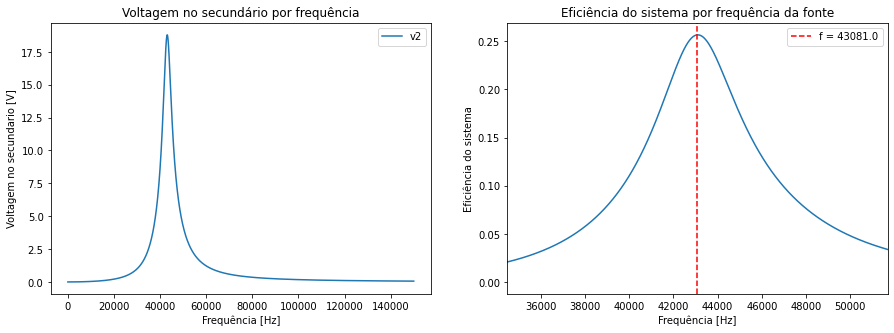

In [11]:
p_1 = []
p_2 = []
v2 = []

for i, freq in enumerate(freqs):
    p_1.append((UFQ * i1_list[i].conjugate()) / 2)
    z_c2 = 1 / (freq * 2 * pi * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2_list[i]
    i_rc = u_rcc2 / RC
    v2.append(u_rcc2)
    p_2.append(np.abs((u_rcc2 * i_rc.conjugate()) / 2))
    m = k * math.sqrt(L1 * L2)

eficiencia = [np.abs(p_2[i]) / np.abs(p_1[i]) for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]
print(f"Potencia maxima no secundario: {np.abs(max(p_2))} W")

plt.figure(figsize=(15, 5))
plt.plot(freqs, np.abs(p_1), label='Potência entrada')
plt.plot(freqs, p_2, label='Potência saída')
plt.title("Potência nas bobinas por frequência da fonte")
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.xlabel("Frequência [Hz]")
plt.ylabel("Potência real [W]")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(freqs, np.abs(v2), label='v2')
ax1.set_title("Voltagem no secundário por frequência")
ax1.set_xlabel("Frequência [Hz]")
ax1.set_ylabel("Voltagem no secundario [V]")
ax1.legend()

ax2.plot(freqs, np.real(eficiencia))
ax2.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
ax2.set_title("Eficiência do sistema por frequência da fonte")
ax2.legend()
ax2.set_xlabel("Frequência [Hz]")
ax2.set_ylabel("Eficiência do sistema")
ax2.set_xlim(f - 0.2*f, f + 0.2*f)
plt.show()

<div id="grafico-s-k-q"></div>

___

### Gráfico da tensão no secundário por k - modelo atualizado.

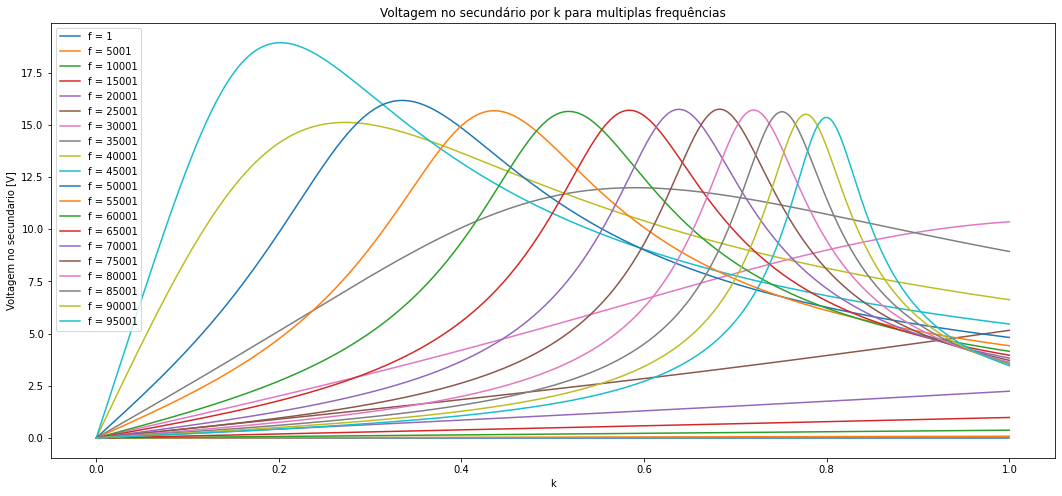

In [12]:
fig = plt.figure(figsize=(18, 8))
k_space = np.linspace(0, 1, 1000)
for f in range(1, 100_000, 5_000):
    v_2 = []
    for k in k_space:
        w = 2 * pi * f
        m = k * math.sqrt(L1 * L2)       
        i1, i2 = CalcularTransformador(UFQ, RC, w, k)
        z_c2 = 1 / (w * C2 * 1j)
        z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
        # Tensão no secundário
        u_rcc2 = z_rcc2 * i2

        v_2.append(np.abs(u_rcc2))
    plt.plot(k_space, v_2, label=f"f = {f}")

plt.title("Voltagem no secundário por k para multiplas frequências")
plt.xlabel("k")
plt.ylabel("Voltagem no secundario [V]")
plt.legend(loc='upper left')
plt.show()

<div id="res-ini"></div>

____

## Resultados parciais.
Feito a simulação, o grupo foi ao laboratório do Insper para fazer o experimento com as bobinas construídas, usando o circuito construido, uma carga de 100 $\Omega$ no secundário, uma tensão de 10 V na alimentação do primário e um osciloscópio para medir a tensão alternada na carga, foi obtido uma tensão de pico de 19.3 V, usando a fórmula: $$P_{carga} = \frac{U_{ef}^2}{R_{carga}}$$ Obtivemos uma potência de **1.862 W**, próximo aos **1.766 W** previstos pelo modelo, o vídeo desse experimênto pode ser visto [nesse link](https://youtu.be/x0fUzKlQoA8).

<div id='iter'><div/>

___

## Problema no circuito.
Devido à alta frequência usada para transmitir a energia, a resistência dos conectores (predominantemente jumpers) não era desprezível, muito pelo contrário, a resistência medida de apenas um jumper em 43.2 kHz chega perto da resistência das bobinas (aprox 0.36 $\Omega$ x 0.459 $\Omega$), isso pode ser observado na imagem abaixo, de uma medição de resistência de um jumper no LCR no laboratório do Insper.

<img src="imgs/jumperLCR.jpg" style="width: 50%;" alt="Medicao LCR" />

É possível ter uma idea de como funciona essa relação da resistência com a frequência, ocasionada pelo efeito pelicular a partir do gráfico abaixo.

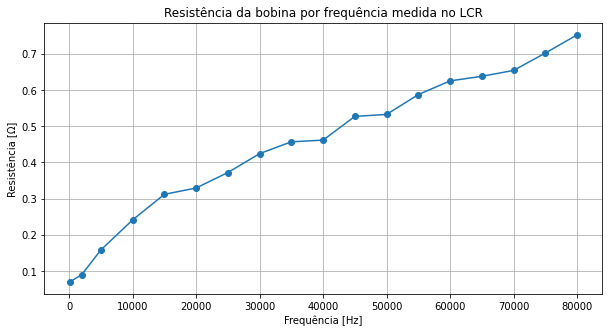

In [13]:
# Resistência medida na bobina para multiplas frequências
freqs_medidas = [120, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000]
res_medidas = [69.56e-3, 89.94e-3, 157.9e-3, 240.9e-3, 311.6e-3, 329.1e-3, 371.9e-3, 424.1e-3, 456.8e-3, 461.4e-3, 527e-3, 532.5e-3, 587.3e-3, 625.1e-3, 637.8e-3, 654e-3, 702.1e-3, 752.3e-3]

fig = plt.figure(figsize=(10, 5))
plt.plot(freqs_medidas, res_medidas, 'o-')
plt.title("Resistência da bobina por frequência medida no LCR")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Resistência [Ω]")
plt.grid()
plt.show()

<div id="novo-circ"></div>

## Iteração para o sistema.
Pensando no problema identificado acima, foi feita um **PCB** com uma placa de fenolite (pode ser vista na imagem abaixo), objetivando diminuir a resistência do circuito, além de separar a alimentação do Circuito integrado e dos mosfets para elevar a tensão máxima que pode ser alimentada ao circuito. 

<img src="imgs/CircuitoPrimario.jpeg" alt="Imagem da plaquinha feita" style="width: 35%;"/>

## Novas variáveis elétricas para o modelo.

In [14]:
R1 = 0.4577 * 2.25 
R2 = 0.4594 * 2.25
UF = 33
UFQ = (2 / np.pi) * UF


<div id="grafico-i-fq-iter"></div>

___

### Gráfico das correntes em função da frequência - sistema iterado.

Freq onde o I1 e max: 43113.0


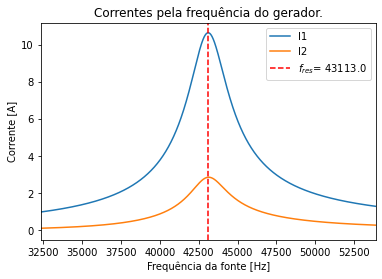

In [15]:
i1_list = []
i2_list = []
p_1 = []
p_2 = []
v2 = []

k = 0.1

m = k * math.sqrt(L1 * L2)   

for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(UFQ, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)
    p_1.append((UFQ * i1.conjugate()) / 2)
    z_c2 = 1 / (w * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2
    i_rc = u_rcc2 / RC
    v2.append(u_rcc2)
    p_2.append(np.abs((u_rcc2 * i_rc.conjugate()) / 2))

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}")

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.axvline(f_res, color='red', linestyle='dashed', label=f'$f_{{res}}$= {f_res:.1f}')
plt.title("Correntes pela frequência do gerador.")
plt.xlabel('Frequência da fonte [Hz]')
plt.ylabel("Corrente [A]")
plt.legend()
plt.xlim(f_res - 0.25 * f_res, f_res + 0.25 * f_res)
plt.show()

<div id='grafico-p-eq-iter'></div>

___

### Gráficos das potências e eficiência - sistema iterado.

Potencia maxima no secundario: 49.22383049662144 W


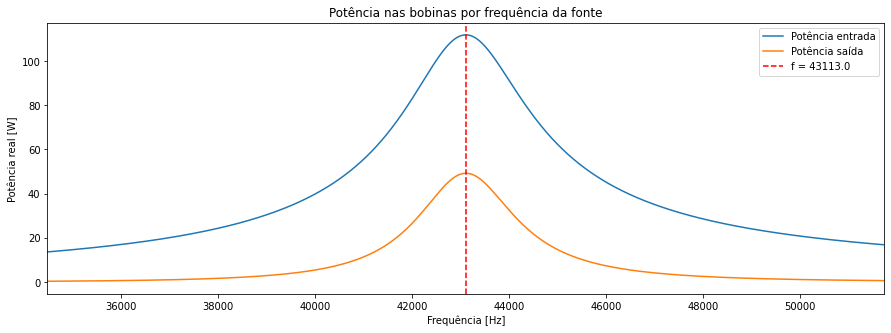

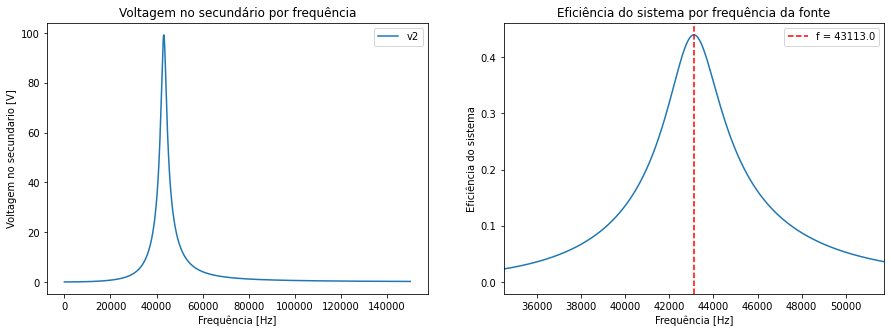

In [16]:
eficiencia = [np.abs(p_2[i]) / np.abs(p_1[i]) for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]
print(f"Potencia maxima no secundario: {np.abs(max(p_2))} W")

plt.figure(figsize=(15, 5))
plt.plot(freqs, np.abs(p_1), label='Potência entrada')
plt.plot(freqs, p_2, label='Potência saída')
plt.title("Potência nas bobinas por frequência da fonte")
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.xlabel("Frequência [Hz]")
plt.ylabel("Potência real [W]")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(freqs, np.abs(v2), label='v2')
ax1.set_title("Voltagem no secundário por frequência")
ax1.set_xlabel("Frequência [Hz]")
ax1.set_ylabel("Voltagem no secundario [V]")
ax1.legend()

ax2.plot(freqs, np.real(eficiencia))
ax2.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
ax2.set_title("Eficiência do sistema por frequência da fonte")
ax2.legend()
ax2.set_xlabel("Frequência [Hz]")
ax2.set_ylabel("Eficiência do sistema")
ax2.set_xlim(f - 0.2*f, f + 0.2*f)
plt.show()

<div id="res-fin"></div>

## Resultados experimentais finais.

___

No laboratório do Insper, ligamos à bobina a alimentação usando um gerador DC e um gerador de sinais com frequência de 43 kHz e medimos a voltagem em uma carga de 100 $\Omega$.     
Foi medida a uma distância de **20cm** uma voltagem de pico de 100 V na carga do secundário, pela fórmula $P = \dfrac{U_{ef}^2}{R}$, chegamos a uma potência de **50 W**, muito próximo aos 49.22 W previstos pelo modelo, um vídeo desse experimento pode ser visto [nesse link do youtube](https://youtu.be/jJEfETpH_lY).

Foi feito também um teste para distâncias maiores, e foi possível transmitir com a mesma carga e voltagem, e foi medida uma tensão de pico com o valor de 45.7 V a **33cm**, o que dá uma potência de **10.44 W** na carga do secundário, o vídeo do experimento pode ser visto [nesse link](https://www.youtube.com/watch?v=NGXswR7GArU).

Por fim, foi feito o teste da máxima distância que poderiamos acender **3 LEDS**, para isso conectamos uma ponte retificadora no circuito do secundário e distanciamos a bobina, a distância máxima foi de **63cm**, como pode ser observado na imagens abaixo.

![Foto leds acesos](imgs/LedsAcesos63cm.jpg)
![Foto da distancia medida](imgs/DistanciaTrena.jpg)